In [383]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import itertools
import math
import pennylane as qml
from pennylane import numpy as pnp
import matplotlib.pyplot as plt

# Parameters
N= 2               # number of lattice sites (2,3,4...)
d= 5               # finite dim 
m= 1             # mass
lam= 0.5           # lambda (phi^4 coupling)
omega= 1         # oscillator frequency
periodic= True    # boundary conditions
max_pauli_terms= 2000  


In [384]:
# Creating a matrix for creation, annhilation operators
def matrix(d):
    eigenstate = []
    rows = []
    cols = []
    for n in range(d-1):
        rows.append(n)
        cols.append(n+1)
        eigenstate.append(np.sqrt(n+1))
    return sp.csr_matrix((eigenstate,(rows,cols)), shape=(d,d), dtype=complex)

print(matrix(d))

<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 4 stored elements and shape (5, 5)>
  Coords	Values
  (0, 1)	(1+0j)
  (1, 2)	(1.4142135623730951+0j)
  (2, 3)	(1.7320508075688772+0j)
  (3, 4)	(2+0j)


In [385]:
"Hamiltonian H has terms phi^2 , pi^2, phi^4 which act on single sites and interaction term (phi_i+1-phi_i)^2 acting on more than one state for which tensor product is necessary"
# Single-site operators
a= matrix(d) #annhilation operator
adag= np.transpose(np.conjugate(a)) #creation operator
phi_single= (a+adag)/np.sqrt(2*omega) # position operator 
pi_single= -1j*np.sqrt(omega/2)*(a-adag) #conjugate momentum

In [386]:
I_d = sp.identity(d, format='csr', dtype=complex)

# Taking the Kronecker product
def kron_prod_sparse(Hamiltonian_single):
    result=Hamiltonian_single[0]
    for M in Hamiltonian_single[1:]:
        result=sp.kron(result, M, format='csr')
    return result
# Positioning each operator in the global Hamiltonian matrix
def op_on_site(single_op,site,N):
    Hamiltonian_single = [I_d]*N
    Hamiltonian_single[site]=single_op
    return kron_prod_sparse(Hamiltonian_single)

# Building the global Hamiltonian
def build_hamiltonian(N,d,m,lam,omega,periodic=False):
    dim = d**N
    H = sp.csr_matrix((dim,dim), dtype=complex)
    # on-site terms
    phi2 = phi_single.dot(phi_single)
    phi4 = phi2.dot(phi2)
    pi2 = pi_single.dot(pi_single)

    for i in range(N):
        H+= 1/2 *op_on_site(pi2,i,N)
        H+= 1/2 *m**2 * op_on_site(phi2,i,N)
        H+= 1/4 *lam* op_on_site(phi4,i,N)

    # (phi_i - phi_j)^2 / 2 term
    for i in range(N):
        j=np.remainder(i+1,N) if periodic else i+1
        if j>= N:
            continue
        phi_i=op_on_site(phi_single,i,N)
        phi_j=op_on_site(phi_single,j,N)
        diff=phi_i-phi_j
        H+=1/2*np.dot(diff,diff)

    # ensure Hermitian numeric
    H=(H+np.transpose(np.transpose(H)))/2
    return H


In [387]:
# Reference diagonalization

def reference_groundstate(H,k=1,which='SA'):
    if min(H.shape)<=2000:
        vals,vecs= np.linalg.eigh(H.toarray())
        return vals[0].real,vecs[:,0]
    else:
        vals,vecs= spla.eigsh(H,k=k,which=which)
        idx= np.argsort(vals)
        return vals[idx[0]].real,vecs[:,idx[0]]


In [388]:
# Mapping Fock to qubit
def build_binary_embedding(N,d):
    k=int(np.ceil(np.log2(d)))#We need 2^k>=d so that all physical states at that site fit in the qubit space
    total_qubits=k*N
    dim=d**N
    dim_qubit=2**total_qubits
    U= sp.lil_matrix((dim_qubit,dim), dtype=complex)
    fock_indices= list(itertools.product(range(d),repeat=N))
    for col_idx,fock_state in enumerate(fock_indices):
        bits=[]
        for n in fock_state:
            b= bin(n)[2:].zfill(k)
            bits.append(b)
        bitstring=''
        for i in bits[::-1]:
            bitstring+= i
        comp_index=int(bitstring,2)
        U[comp_index,col_idx]=1
    return U.tocsr(),total_qubits

# Projector onto the embedded Fock subspace
U, total_qubits= build_binary_embedding(N, d)
U_full= U.toarray()

# Build projector onto physical subspace
Pi= np.dot(U_full,np.transpose(np.conjugate(U_full)))

trace_Pi= np.trace(Pi).real #checks that all Fock states are included
print("Trace:",trace_Pi," expected:",d**N)

proj_error= np.linalg.norm(np.dot(Pi,Pi) - Pi) #checks that Pi is a valid projector (idempotent)
print("error =",proj_error)


Trace: 25.0  expected: 25
error = 0.0


In [389]:
dim_qubit = H_qubit.shape[0] #full qubit space

#Picking a physical basis vector
phys_idx= np.where(np.sum(U.toarray(),axis=1) > 0)[0][0]  #first row with nonzero entries
phys_vec= U.toarray()[:,phys_idx]
phys_vec= phys_vec/np.linalg.norm(phys_vec)
E_phys= np.real(np.vdot(phys_vec, H_qubit @ phys_vec))
# Picking a null qubit-space vector
all_basis= np.eye(dim_qubit, dtype=complex)
for i in range(dim_qubit):
    if np.allclose(Pi[i, i],0):
        null_vec= all_basis[:, i]
        break
E_null= np.real(np.vdot(null_vec,H_qubit @ null_vec))
print("Energy of mapped basis state:",E_phys)
print("Energy of unused (null) basis state:",E_null)

Energy of mapped basis state: 2.1875
Energy of unused (null) basis state: 0.0


In [390]:
alpha= 50  # choose larger than typical ground-state energy
dim_qubit= H_qubit.shape[0]
I= np.eye(dim_qubit)

# Penalized Hamiltonian
H_qubit_penalized= H_qubit+alpha*(I-Pi)
#alpha acts like a barrier that keeps the variational algorithm constrained to valid states since (I−Pi) picks out any unphysical components,and a large energy penalty alpha is added to any component in the unphysical space.


In [391]:
# Pauli matrices (dense small) 
_paulis = {'I': np.array([[1,0],[0,1]], dtype=complex),
    'X': np.array([[0,1],[1,0]], dtype=complex),
    'Y': np.array([[0,-1j],[1j,0]], dtype=complex),
    'Z': np.array([[1,0],[0,-1]], dtype=complex)}

In [392]:
# Pauli decomposition 
def pauli_decompose(H_qubit,max_terms=1000,tol=1e-12):
    dim= H_qubit.shape[0]
    Q= int(np.log2(dim))
    assert 2**Q== dim
    H= H_qubit
    terms= []
    # iterate over pauli strings 
    chars= ['I','X','Y','Z']
    for pauli_string in itertools.product(chars,repeat=Q):
        # build operator
        m= [_paulis[c] for c in pauli_string]
        P= m[0]
        for M in m[1:]:
            P= np.kron(P, M)
        coeff= np.trace(P.conj().T.dot(H)) / dim
        if abs(coeff)> tol:
            terms.append((coeff, ''.join(pauli_string)))
        if len(terms)>= max_terms:
            break

    terms.sort(key=lambda x:-abs(x[0]))
    return terms

In [393]:
# Converting pauli terms to pennylane Hamiltonian
def pauli_terms_to_qml_hamiltonian(pauli_terms):
    coeffs=[]
    obs=[]
    for coeff, pstr in pauli_terms:
        opt=[]
        for q,c in enumerate(pstr):
            if c=='I':
                continue
            if c=='X':
                opt.append(qml.PauliX(wires=q))
            if c=='Y':
                opt.append(qml.PauliY(wires=q))
            if c=='Z':
                opt.append(qml.PauliZ(wires=q))
        if len(opt)==0:
            obs.append(qml.Identity(wires=0))
        elif len(opt)==1:
            obs.append(opt[0])
        else:
            # tensor product of ops
            tens= opt[0]
            for op in opt[1:]:
                tens= tens @ op
            obs.append(tens)
        coeffs.append(np.real_if_close(coeff))
    return qml.Hamiltonian(coeffs,obs)

In [394]:
# VQE (pennylane)
def run_vqe(H_qubit,total_qubits,init_layers=2,maxiter=500,printing_gap=10):
    H_dense= np.array(H_qubit.todense()) if sp.issparse(H_qubit) else np.array(H_qubit)
    pauli_terms= pauli_decompose(H_dense, max_terms=max_pauli_terms)
    print("Number of pauli terms:{len(pauli_terms)}")

    ham= pauli_terms_to_qml_hamiltonian(pauli_terms)
    dev= qml.device("default.qubit", wires=total_qubits)

    n_layers= init_layers
    ansatz= qml.templates.StronglyEntanglingLayers

    @qml.qnode(dev, interface='autograd')
    def circuit(params):
        ansatz(params,wires=list(range(total_qubits)))
        return qml.expval(ham)

    params= pnp.array(0.1 * np.random.randn(n_layers, total_qubits, 3), requires_grad=True)
    opt= qml.AdamOptimizer(stepsize=0.05)
    energies=[]
    all_params = []

    for it in range(maxiter):
        params,energy= opt.step_and_cost(circuit, params)
        energies.append(energy)
        if it % printing_gap== 0 or it== maxiter-1:
            print(f"Iter {it:4d}- E={energy:.8f}")
    return energies,energies[-1]

Hamiltonian dimension: (25, 25)
Reference ground energy: 1.6844487824446772
Total qubits (binary encoding): 6
Number of pauli terms:{len(pauli_terms)}
Iter    0- E=3.24152768
Iter   10- E=2.14630844
Iter   20- E=2.01991015
Iter   30- E=1.99246424
Iter   40- E=1.98827436
Iter   50- E=1.98667486
Iter   60- E=1.98541155
Iter   70- E=1.98532633
Iter   80- E=1.98521251
Iter   90- E=1.98516137
Iter  100- E=1.98510942
Iter  110- E=1.98509811
Iter  119- E=1.98509716
VQE final energy: 1.9850971619131583


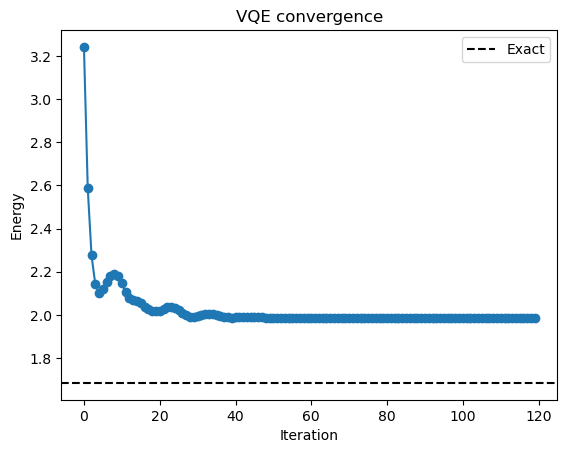

In [395]:
# Execution example
H= global_hamiltonian(N,d,m,lam,omega,periodic=periodic)
print("Hamiltonian dimension:", H.shape)

E0_ref,psi0= reference_groundstate(H)
print("Reference ground energy:", E0_ref)

# Map to qubit space
U,total_qubits= build_binary_embedding(N,d)
print("Total qubits (binary encoding):", total_qubits)
dim_qubit= 2**total_qubits
# embed H into qubit space
H_qubit= np.dot(np.dot(U,H),U.getH())

if total_qubits<= 8:
    energies,E_vqe= run_vqe(H_qubit_penalized,total_qubits,init_layers=2,maxiter=120,printing_gap=10)
    print("VQE final energy:",E_vqe)
    # plot convergence
    plt.plot(energies,marker='o')
    plt.axhline(E0_ref,color='k',linestyle='--',label='Exact')
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
    plt.legend()
    plt.title('VQE convergence')
    plt.show()
else:
     print('Qubit space too large...')


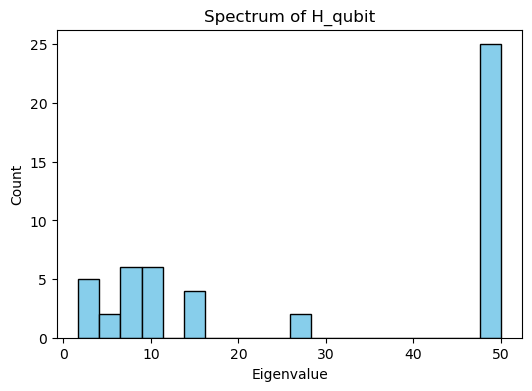

In [396]:
vals, _ = spla.eigsh(H_qubit_penalized, k=min(50, H_qubit_penalized.shape[0]), which='SA')
plt.figure(figsize=(6,4))
plt.hist(vals.real, bins=20, color='skyblue', edgecolor='k')
plt.xlabel('Eigenvalue')
plt.ylabel('Count')
plt.title('Spectrum of H_qubit')
plt.show()


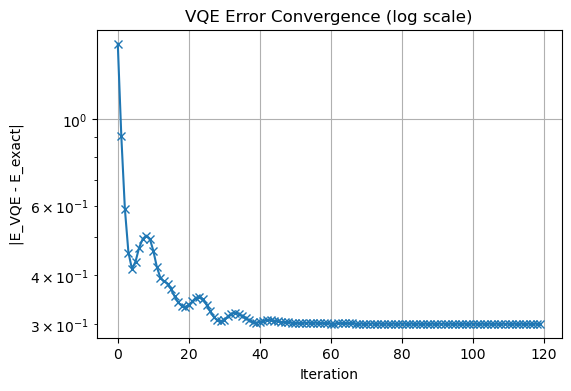

In [397]:
errors = [abs(e - E0_ref) for e in energies]
plt.figure(figsize=(6,4))
plt.semilogy(errors, marker='x')
plt.xlabel('Iteration')
plt.ylabel('|E_VQE - E_exact|')
plt.title('VQE Error Convergence (log scale)')
plt.grid(True)
plt.show()
